# 目录
+ K折交叉验证
+ 自动进行交叉验证并评分
+ 随机交叉验证
+ 分层K折交叉验证
+ 原生Python的Grid Search
+ Grid Search
+ 用虚拟模型建立baseline
+ 评估回归模型
+ 特征选择
+ L1特征选择
+ 用joblib保存模型

In [1]:
from pandas import DataFrame, Series
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
%matplotlib inline

# K折交叉验证
model_selection.KFold类

In [3]:
from sklearn.model_selection import KFold

In [4]:
# 创建1000个样本的回归数据集
N = 1000
holdout = 200
from sklearn.datasets import make_regression
X, y = make_regression(1000, shuffle=True)

In [5]:
# 取200个样本做测试集，余下800个样本做训练集，用交叉验证做参数调优
X_h, y_h = X[:holdout], y[:holdout]
X_t, y_t = X[holdout:], y[holdout:]

In [6]:
# 生成KFold对象，4折交叉验证
kfold = KFold(n_splits=4)

In [7]:
# split方法生成将数据集切分为训练集、验证集的索引
output_string = "Fold: {}, N_train: {}, N_test: {}"

for i, (train, test) in enumerate(kfold.split(X_t)):
    print output_string.format(i, len(y_t[train]), len(y_t[test]))

Fold: 0, N_train: 600, N_test: 200
Fold: 1, N_train: 600, N_test: 200
Fold: 2, N_train: 600, N_test: 200
Fold: 3, N_train: 600, N_test: 200


In [8]:
# KFold对象是一个generator对象（生成器），用for循环来调用
type(kfold.split(X_t))

generator

## 示例
长格式的数据集：每个样本占了8行，切分训练集和验证集时需要进行层次切分，即按照病人ID进行切分

In [9]:
# 创建包含100个病人和8次检查结果的数据集
import numpy as np
import pandas as pd

# 100个病人，每个病人有8次检查，因而病人ID重复8次
patients = np.repeat(np.arange(0, 100, dtype=np.int8), 8)

# 用随机数代表病人的8次检查结果，生成数据框
measurements = pd.DataFrame({'patient_id': patients, 'ys': np.random.normal(0, 1, 800)})

measurements.head()

,patient_id,ys
0,0,-0.299172
1,0,0.863376
2,0,-1.579346
3,0,-0.444232
4,0,1.228710


In [10]:
# 返回病人ID（0-99）
custids = np.unique(measurements.patient_id)

# 生成4折交叉验证的对象
customer_kfold = KFold(n_splits=4)

output_string = "Fold: {}, N_train: {}, N_test: {}"

for i, (train, test) in enumerate(customer_kfold.split(custids)): # 将病人ID进行4折切分
    
    train_cust_ids = custids[train]
    
    # 在measurements数据集上切分成训练集
    training = measurements[measurements.patient_id.isin(train_cust_ids)]
    # 在measurements数据集上切分成验证集
    testing = measurements[~measurements.patient_id.isin(train_cust_ids)]
    
    print output_string.format(i, len(training), len(testing))

Fold: 0, N_train: 600, N_test: 200
Fold: 1, N_train: 600, N_test: 200
Fold: 2, N_train: 600, N_test: 200
Fold: 3, N_train: 600, N_test: 200


# 自动进行交叉验证并评分
model_selection.cross_val_score类

In [11]:
from sklearn import model_selection

In [12]:
# 用随机森林回归模型作为示例
from sklearn import ensemble
rf = ensemble.RandomForestRegressor(max_features='auto')

In [13]:
# 创建回归数据集
from sklearn import datasets
X, y = datasets.make_regression(10000, 10)

In [14]:
# 默认进行3折交叉验证，为模型评分
scores = model_selection.cross_val_score(rf, X, y)

In [15]:
print scores

[ 0.87554292  0.87905026  0.87709637]


In [16]:
# 设置4折交叉验证，设置verbose显示交叉验证详细过程（每一轮的评分、用时等）
scores = model_selection.cross_val_score(rf, X, y, verbose=3, cv=4)

[CV]  ................................................................
[CV] ....................................... , score=0.879888 -   0.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV] ....................................... , score=0.886936 -   0.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s remaining:    0.0s


[CV] ....................................... , score=0.880647 -   0.0s
[CV]  ................................................................
[CV] ....................................... , score=0.875245 -   0.0s


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    2.5s finished


# 随机交叉验证
model_selection.ShuffleSplit类

In [17]:
from sklearn.model_selection import ShuffleSplit

In [18]:
# 生成数据集，1000个样本，服从N(1000, 10)的正态分布
import numpy as np

true_loc = 1000
true_scale = 10
N = 1000

dataset = np.random.normal(true_loc, true_scale, N)

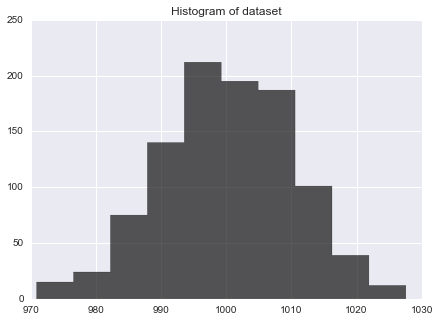

In [19]:
# 数据集服从正态分布
import matplotlib.pyplot as plt

f, ax = plt.subplots(figsize=(7, 5))

ax.hist(dataset, color='k', alpha=.65, histtype='stepfilled');
ax.set_title("Histogram of dataset");

In [20]:
# 取数据集中一半样本估计其均值
holdout_set = dataset[:500]
fitting_set = dataset[500:]

In [21]:
estimate = fitting_set[:N/2].mean()

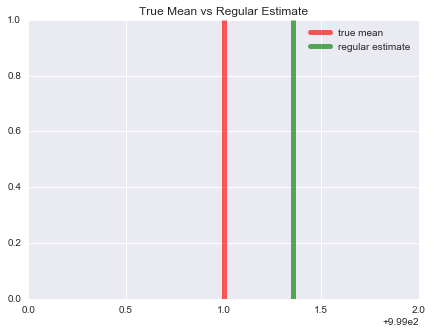

In [22]:
import matplotlib.pyplot as plt

f, ax = plt.subplots(figsize=(7, 5))

ax.set_title("True Mean vs Regular Estimate")

ax.vlines(true_loc, 0, 1, color='r', linestyles='-', lw=5, alpha=.65, label='true mean')
ax.vlines(estimate, 0, 1, color='g', linestyles='-', lw=5, alpha=.65, label='regular estimate')

ax.set_xlim(999, 1001)

ax.legend();

In [23]:
from sklearn.model_selection import ShuffleSplit

In [24]:
# 生成ShuffleSplit对象，默认10折（随机选取10%的样本作为验证集，剩下样本作为训练集，如此循环10次）
# 不同于普通交叉验证每一折都是严格区分不重复，随机交叉验证，每一次循环中验证集都是随机选取的，因此有可能重复
shuffle_split = ShuffleSplit()

In [25]:
mean_p = []

for train, _ in shuffle_split.split(fitting_set):
    mean_p.append(fitting_set[train].mean())
    
shuf_estimate = np.mean(mean_p)

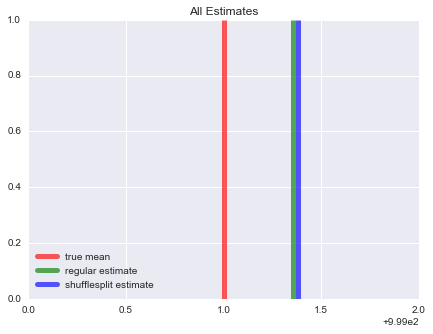

In [26]:
import matplotlib.pyplot as plt

f, ax = plt.subplots(figsize=(7, 5))

ax.vlines(true_loc, 0, 1, color='r', linestyles='-', lw=5, alpha=.65, label='true mean')
ax.vlines(estimate, 0, 1, color='g', linestyles='-', lw=5, alpha=.65, label='regular estimate')
ax.vlines(shuf_estimate, 0, 1, color='b', linestyles='-', lw=5, alpha=.65, label='shufflesplit estimate')

ax.set_title("All Estimates")
ax.set_xlim(999, 1001)

ax.legend(loc=3);

# 分层K折交叉验证
StratifiedKFold类

In [27]:
from sklearn.model_selection import StratifiedKFold

In [28]:
# 创建不平衡的分类数据集
from sklearn import datasets
X, y = datasets.make_classification(n_samples=int(1e3), weights=[1./11])

In [29]:
# 90.3%正例
y.mean()

0.90400000000000003

In [30]:
n_splits = 50

strat_kfold = StratifiedKFold(n_splits=n_splits)
shuff_split = ShuffleSplit(n_splits=n_splits)

In [31]:
kfold_y_props = []
shuff_y_props = []

for (k_train, k_test), (s_train, s_test) in zip(strat_kfold.split(X, y), shuff_split.split(X)):
    
    # 分层10折交叉验证
    kfold_y_props.append(y[k_train].mean())
    # 随机10折交叉验证
    shuff_y_props.append(y[s_train].mean())

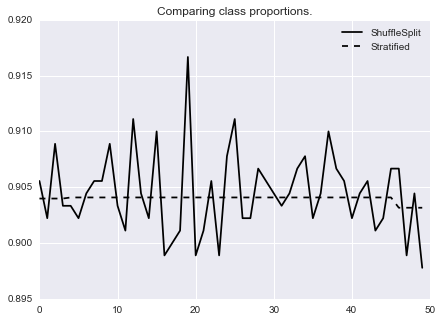

In [32]:
# 随机交叉验证，每一折训练集正例上下波动；分层交叉验证，每一折训练集正例不变
f, ax = plt.subplots(figsize=(7, 5))

ax.plot(range(n_splits), shuff_y_props, label="ShuffleSplit", color='k')
ax.plot(range(n_splits), kfold_y_props, label="Stratified", color='k', ls='--')
ax.set_title("Comparing class proportions.")

ax.legend(loc='best');

In [33]:
three_classes_X = np.arange(1000)
three_classes_y = np.random.choice([1,2,3], p=[.1, .4, .5], size=1000)

In [34]:
strat_test = StratifiedKFold(5)

# np.bincount求出每一次选出的训练集中1、2、3类的样本数，可以看出，每一个训练集的样本类别比例基本保持不变
for train, test in strat_test.split(three_classes_X, three_classes_y):
    print np.bincount(three_classes_y[train])

[  0  89 331 379]
[  0  89 331 379]
[  0  90 331 379]
[  0  90 331 379]
[  0  90 332 380]


# 原生Python的Grid Search

待选择参数的模型为决策树模型，参数空间为2维：

$$
\text{criteria} = \{\text{gini}, \text{entropy}\}
$$

$$
\text{max_features} = \{\text{auto}, \text{log2}, \text{None}\}
$$

参数空间为：

$$
\text{parameter space} = \text{criteria} \times \text{max_features}
$$

In [35]:
# 创建分类数据集
from sklearn import datasets
X, y = datasets.make_classification(n_samples=2000, n_features=10)

In [36]:
# 生成参数空间
criteria = {'gini', 'entropy'}
max_features = {'auto', 'log2', None}

import itertools as it

parameter_space = it.product(criteria, max_features)

In [37]:
# 一半样本点为训练集，另一半样本点为验证集
import numpy as np
train_set = np.random.choice([True, False], size=len(y))

In [38]:
# 对每一组参数训练一个决策树模型，并将其损失函数的结果保存在字典中

from sklearn.tree import DecisionTreeClassifier

accuracies = {}

for criterion, max_feature in parameter_space:
    dt = DecisionTreeClassifier(criterion=criterion, max_features=max_feature)
    
    dt.fit(X[train_set], y[train_set])
    
    accuracies[(criterion, max_feature)] = (dt.predict(X[~train_set]) == y[~train_set]).mean()

In [39]:
accuracies

{('entropy', None): 0.83623336745138177,
 ('entropy', 'auto'): 0.86182190378710333,
 ('entropy', 'log2'): 0.87001023541453426,
 ('gini', None): 0.86489252814738993,
 ('gini', 'auto'): 0.87512794268167859,
 ('gini', 'log2'): 0.86386898669396106}

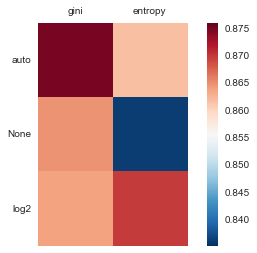

In [40]:
# 通过比较损失函数的大小，在参数空间中选择最优的参数

from matplotlib import pyplot as plt

from matplotlib import cm
cmap = cm.RdBu_r

f, ax = plt.subplots(figsize=(7, 4))

ax.set_xticklabels([''] + list(criteria))
ax.set_yticklabels([''] + list(max_features))

plot_array = []


for max_feature in max_features:
    
    m = []
    for criterion in criteria:
        
        m.append(accuracies[(criterion, max_feature)])
        
    plot_array.append(m)

colors = ax.matshow(plot_array,
                    vmin=np.min(accuracies.values()) - 0.001,
                    vmax=np.max(accuracies.values()) + 0.001,
                    cmap=cmap)

plt.grid(False)

f.colorbar(colors);

# Grid Search
GridSearchCV类和RandomizedSearchCV类

In [41]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [42]:
# 创建分类数据集
from sklearn.datasets import make_classification
X, y = make_classification(1000, n_features=5)

In [43]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(class_weight='balanced')

In [44]:
lr.fit(X, y)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

## Grid Search

In [45]:
# 生成GridSearch的参数空间
grid_search_params = {
    'penalty': ['l1', 'l2'],
    'C': [1, 2, 3, 4]
}

In [46]:
gs = GridSearchCV(lr, grid_search_params)
gs.fit(X, y)

GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'penalty': ['l1', 'l2'], 'C': [1, 2, 3, 4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [47]:
gs.cv_results_

{'mean_fit_time': array([ 0.00266663,  0.00133332,  0.00266663,  0.0013334 ,  0.00533326,
         0.00266671,  0.00266663,  0.        ]),
 'mean_score_time': array([ 0.        ,  0.        ,  0.00033339,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ]),
 'mean_test_score': array([ 0.931,  0.931,  0.931,  0.931,  0.931,  0.931,  0.931,  0.931]),
 'mean_train_score': array([ 0.93249772,  0.93249847,  0.93299822,  0.93299897,  0.93299897,
         0.93299897,  0.93299897,  0.93299897]),
 'param_C': masked_array(data = [1 1 2 2 3 3 4 4],
              mask = [False False False False False False False False],
        fill_value = ?),
 'param_penalty': masked_array(data = ['l1' 'l2' 'l1' 'l2' 'l1' 'l2' 'l1' 'l2'],
              mask = [False False False False False False False False],
        fill_value = ?),
 'params': ({'C': 1, 'penalty': 'l1'},
  {'C': 1, 'penalty': 'l2'},
  {'C': 2, 'penalty': 'l1'},
  {'C': 2, 'penalty': 'l2'},
  {'C': 3, 'penalty': 'l1'},
  {'

In [48]:
# 用数据框形式展示
DataFrame(gs.cv_results_)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_C,param_penalty,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.002667,0.000000,0.931,0.932498,1,l1,"{u'penalty': u'l1', u'C': 1}",1,0.937126,0.927928,0.930931,0.935532,0.924925,0.934033,0.001886,0.000000,0.004982,0.003289
1,0.001333,0.000000,0.931,0.932498,1,l2,"{u'penalty': u'l2', u'C': 1}",1,0.937126,0.929429,0.930931,0.935532,0.924925,0.932534,0.001886,0.000000,0.004982,0.002492
2,0.002667,0.000333,0.931,0.932998,2,l1,"{u'penalty': u'l1', u'C': 2}",1,0.937126,0.929429,0.930931,0.935532,0.924925,0.934033,0.001247,0.000471,0.004982,0.002597
3,0.001333,0.000000,0.931,0.932999,2,l2,"{u'penalty': u'l2', u'C': 2}",1,0.937126,0.930931,0.930931,0.935532,0.924925,0.932534,0.001886,0.000000,0.004982,0.001907
4,0.005333,0.000000,0.931,0.932999,3,l1,"{u'penalty': u'l1', u'C': 3}",1,0.937126,0.930931,0.930931,0.935532,0.924925,0.932534,0.001886,0.000000,0.004982,0.001907
5,0.002667,0.000000,0.931,0.932999,3,l2,"{u'penalty': u'l2', u'C': 3}",1,0.937126,0.930931,0.930931,0.935532,0.924925,0.932534,0.001886,0.000000,0.004982,0.001907
6,0.002667,0.000000,0.931,0.932999,4,l1,"{u'penalty': u'l1', u'C': 4}",1,0.937126,0.930931,0.930931,0.935532,0.924925,0.932534,0.001886,0.000000,0.004982,0.001907
7,0.000000,0.000000,0.931,0.932999,4,l2,"{u'penalty': u'l2', u'C': 4}",1,0.937126,0.930931,0.930931,0.935532,0.924925,0.932534,0.000000,0.000000,0.004982,0.001907


In [49]:
# 返回最优的模型
gs.best_estimator_

LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

## RandomizedSearch

In [50]:
# 生成RandomizedSearch的参数空间
import scipy.stats as st
import numpy as np

# 参数是数值时，可以用分布而不是制定具体数值
random_search_params = {
    'penalty': ['l1', 'l2'],
    'C': st.randint(1, 4)
}

In [51]:
rs = RandomizedSearchCV(lr, random_search_params)
rs.fit(X, y)

RandomizedSearchCV(cv=None, error_score='raise',
          estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
          fit_params={}, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'penalty': ['l1', 'l2'], 'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000000000B773278>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring=None, verbose=0)

In [52]:
rs.cv_results_

{'mean_fit_time': array([ 0.00266671,  0.00400003,  0.00166663,  0.00100017,  0.0013334 ,
         0.00399995,  0.00133332,  0.        ,  0.        ,  0.0013334 ]),
 'mean_score_time': array([ 0.00133332,  0.        ,  0.00033339,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ]),
 'mean_test_score': array([ 0.931,  0.931,  0.931,  0.931,  0.931,  0.931,  0.931,  0.931,
         0.931,  0.931]),
 'mean_train_score': array([ 0.93299822,  0.93249772,  0.93299897,  0.93249847,  0.93249847,
         0.93299897,  0.93249772,  0.93299897,  0.93249772,  0.93249847]),
 'param_C': masked_array(data = [2 2 2 1 1 3 2 3 1 1],
              mask = [False False False False False False False False False False],
        fill_value = ?),
 'param_penalty': masked_array(data = ['l1' 'l1' 'l2' 'l2' 'l2' 'l2' 'l1' 'l2' 'l1' 'l2'],
              mask = [False False False False False False False False False False],
        fill_value = ?),
 'params': ({'C': 2

In [53]:
# 用数据框形式展示
DataFrame(rs.cv_results_)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_C,param_penalty,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.002667,0.001333,0.931,0.932998,2,l1,"{u'penalty': u'l1', u'C': 2}",1,0.937126,0.929429,0.930931,0.935532,0.924925,0.934033,0.001886,0.001886,0.004982,0.002597
1,0.004000,0.000000,0.931,0.932498,2,l1,"{u'penalty': u'l1', u'C': 2}",1,0.937126,0.927928,0.930931,0.935532,0.924925,0.934033,0.003266,0.000000,0.004982,0.003289
2,0.001667,0.000333,0.931,0.932999,2,l2,"{u'penalty': u'l2', u'C': 2}",1,0.937126,0.930931,0.930931,0.935532,0.924925,0.932534,0.001700,0.000471,0.004982,0.001907
3,0.001000,0.000000,0.931,0.932498,1,l2,"{u'penalty': u'l2', u'C': 1}",1,0.937126,0.929429,0.930931,0.935532,0.924925,0.932534,0.000000,0.000000,0.004982,0.002492
4,0.001333,0.000000,0.931,0.932498,1,l2,"{u'penalty': u'l2', u'C': 1}",1,0.937126,0.929429,0.930931,0.935532,0.924925,0.932534,0.001886,0.000000,0.004982,0.002492
5,0.004000,0.000000,0.931,0.932999,3,l2,"{u'penalty': u'l2', u'C': 3}",1,0.937126,0.930931,0.930931,0.935532,0.924925,0.932534,0.000000,0.000000,0.004982,0.001907
6,0.001333,0.000000,0.931,0.932498,2,l1,"{u'penalty': u'l1', u'C': 2}",1,0.937126,0.927928,0.930931,0.935532,0.924925,0.934033,0.001886,0.000000,0.004982,0.003289
7,0.000000,0.000000,0.931,0.932999,3,l2,"{u'penalty': u'l2', u'C': 3}",1,0.937126,0.930931,0.930931,0.935532,0.924925,0.932534,0.000000,0.000000,0.004982,0.001907
8,0.000000,0.000000,0.931,0.932498,1,l1,"{u'penalty': u'l1', u'C': 1}",1,0.937126,0.927928,0.930931,0.935532,0.924925,0.934033,0.000000,0.000000,0.004982,0.003289
9,0.001333,0.000000,0.931,0.932498,1,l2,"{u'penalty': u'l2', u'C': 1}",1,0.937126,0.929429,0.930931,0.935532,0.924925,0.932534,0.001886,0.000000,0.004982,0.002492


In [54]:
# 返回最优的模型
rs.best_estimator_

LogisticRegression(C=2, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

# 用虚拟模型建立baseline
DummyRegressor类和DummyClassifier类

In [55]:
from sklearn import dummy

## 回归

In [56]:
# 创建回归数据集
from sklearn.datasets import make_regression
X, y = make_regression()

In [57]:
dumdum = dummy.DummyRegressor()
dumdum.fit(X, y)

DummyRegressor(constant=None, quantile=None, strategy='mean')

In [58]:
dumdum.predict(X)[:5] # 默认情况下，虚拟模型用均值进行预测

array([-15.50396099, -15.50396099, -15.50396099, -15.50396099, -15.50396099])

In [59]:
# 有3种预测方式：均值、中位数、常数，选择常数预测方式时，需要指定用来预测的常数
predictors = [("mean", None),
              ("median", None),
              ("constant", 10)]

for strategy, constant in predictors:
    dumdum = dummy.DummyRegressor(strategy=strategy, constant=constant)
    dumdum.fit(X, y)
    
    print "stragegy: {}".format(strategy), ",".join(map(str, dumdum.predict(X)[:5]))

stragegy: mean -15.5039609856,-15.5039609856,-15.5039609856,-15.5039609856,-15.5039609856
stragegy: median -3.49482464648,-3.49482464648,-3.49482464648,-3.49482464648,-3.49482464648
stragegy: constant 10.0,10.0,10.0,10.0,10.0


## 分类

In [60]:
# 创建分类数据集
from sklearn.datasets import make_classification
X, y = make_classification()

In [61]:
predictors = [("constant", 0),
              ("stratified", None),
              ("uniform", None),
              ("most_frequent", None)]

In [62]:
# 有3种预测方式
for strategy, constant in predictors:
    dumdum = dummy.DummyClassifier(strategy=strategy, constant=constant)
    dumdum.fit(X, y)
    
    print "stragegy: {}".format(strategy), ",".join(map(str, dumdum.predict(X)[:5]))

stragegy: constant 0,0,0,0,0
stragegy: stratified 0,0,0,0,0
stragegy: uniform 1,0,0,1,0
stragegy: most_frequent 0,0,0,0,0


## baseline
虚拟回归的作用是建立一个baseline，用后续建立的模型与之进行对比

In [63]:
# 创建不平衡的分类数据集
X, y = make_classification(20000, weights=[.95, .05])

In [64]:
# 将所有测试集中样本预测为多类，从而得到一个baseline
dumdum = dummy.DummyClassifier(strategy='most_frequent')
dumdum.fit(X, y)

DummyClassifier(constant=None, random_state=None, strategy='most_frequent')

In [65]:
# 后续建立的模型，只有效果比baseline更好，才有意义

from sklearn.metrics import accuracy_score
print accuracy_score(y, dumdum.predict(X))

0.9456


# 评估回归模型
$MSE$：metrics.mean_squared_error类、$MAD$：mean_absolute_error类、$R^2$：r2_score类

In [66]:
# 数据生产过程
m = 2
b = 1

y = lambda x: m*x+b

In [67]:
# 预测值生产过程
def data(x, m=2, b=1, e=None, s=10):
    """  
    Args:
        x: The x value
        m: Slope
        b: Intercept
        e: Error, optional, True will give
            random error
    """
    
    if e is None:
        e_i = 0
    elif e is True:
        e_i = np.random.normal(0, s, len(xs))
    else:
        e_i = e
    
    return x * m + b + e_i

In [68]:
from functools import partial

In [69]:
N = 100
xs = np.sort(np.random.rand(N)*100)

In [70]:
# 生成y的真实值和预测值
y_pred_gen = partial(data, x=xs, e=True)
y_true_gen = partial(data, x=xs)

y_pred = y_pred_gen()
y_true = y_true_gen()

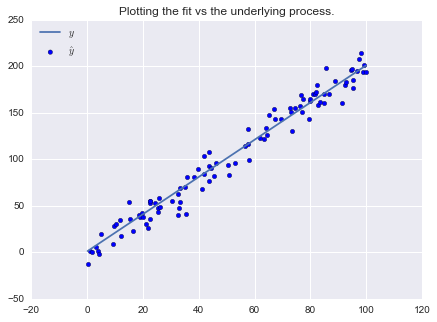

In [71]:
# 点为预测值，直线是数据生成过程，表示真实值
f, ax = plt.subplots(figsize=(7, 5))

ax.set_title("Plotting the fit vs the underlying process.")
ax.scatter(xs, y_pred, label=r'$\hat{y}$')
ax.plot(xs, y_true, label=r'$y$')

ax.legend(loc=2);

In [72]:
# 残差
e_hat = y_pred - y_true

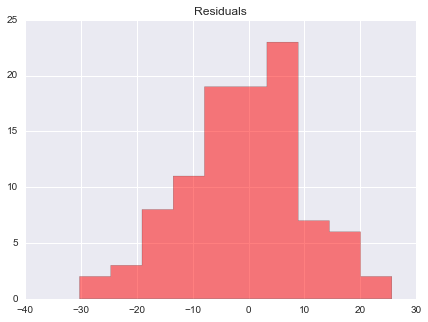

In [73]:
f, ax = plt.subplots(figsize=(7, 5))

ax.set_title("Residuals")
ax.hist(e_hat, color='r', alpha=.5, histtype='stepfilled');

MSE:
$$MSE(y_{true}, y_{pred}) = E((y_{true} - y_{pred})^2)$$

In [74]:
from sklearn import metrics
metrics.mean_squared_error(y_true, y_pred)

118.68683999237582

MAD:
$$MAD(y_{true}, y_{pred}) = E(|y_{true} - y_{pred}|)$$

In [75]:
metrics.mean_absolute_error(y_true, y_pred)

8.7127109268435632

$R^2$: 1 minus the ratio of squared errors for the overall mean and the fit model.  As the ratio tends to 0 the $R^2$ tends to 1.

In [76]:
metrics.r2_score(y_true, y_pred)

0.96755752170232923

# 特征选择
feature_selection.f_regression类和feature_selection.VarianceThreshold类

In [77]:
from sklearn import feature_selection

In [78]:
# 创建回归数据集，1000个样本，10000个特征
from sklearn import datasets
X, y = datasets.make_regression(1000, 10000)

## F值和p值

In [79]:
# f和p是做一元回归时，各个特征的F值和p值
f, p = feature_selection.f_regression(X, y)

In [80]:
f[:5]

array([  0.04435572,  12.3688407 ,   0.46792049,   0.6075195 ,   0.44867836])

In [81]:
p[:5]

array([  8.33236185e-01,   4.56205022e-04,   4.94104198e-01,
         4.35908083e-01,   5.03118195e-01])

In [82]:
# 只保留p值小于0.05的特征
idx = np.arange(0, X.shape[1])
features_to_keep = idx[p < .05]
len(features_to_keep)

553

## 数据的变异程度
变异程度（方差）大的特征包含更多的信息，且由于这种方法只考虑X而不需要y，因而可用于非监督学习

In [83]:
var_threshold = feature_selection.VarianceThreshold(np.median(np.var(X, axis=1)))

In [84]:
var_threshold.fit_transform(X).shape

(1000L, 4877L)

## 示例

In [85]:
# 只有20个特征，便于可视化
X, y = datasets.make_regression(10000, 20)

In [86]:
f, p = feature_selection.f_regression(X, y)

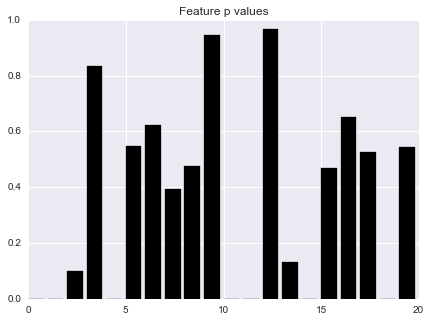

In [87]:
# 只有部分特征的p值显著
f, ax = plt.subplots(figsize=(7, 5))

ax.bar(np.arange(20), p, color='k')
ax.set_title("Feature p values");

# L1特征选择
LassoCV类

In [88]:
from sklearn import feature_selection

In [89]:
# 载入diabetes数据集
import sklearn.datasets
diabetes = datasets.load_diabetes()

In [90]:
# 建立logistics模型
from sklearn import linear_model
lr = linear_model.LinearRegression()

In [91]:
from sklearn import metrics
from sklearn import model_selection
shuff = model_selection.ShuffleSplit()

In [92]:
# 用随机交叉验证，求出模型的MSE
mses = []
for train, test in shuff.split(diabetes.data):
    train_X = diabetes.data[train]
    train_y = diabetes.target[train]
    
    test_X = diabetes.data[~train]
    test_y = diabetes.target[~train]
    
    lr.fit(train_X, train_y)
    
    mses.append(metrics.mean_squared_error(test_y, lr.predict(test_X)))
    
np.mean(mses)

2880.4424441782653

In [93]:
cv = linear_model.LassoCV()
cv.fit(diabetes.data, diabetes.target)
cv.coef_

array([  -0.        , -226.2375274 ,  526.85738059,  314.44026013,
       -196.92164002,    1.48742026, -151.78054083,  106.52846989,
        530.58541123,   64.50588257])

In [94]:
# 找出系数非0的特征索引
columns = np.arange(diabetes.data.shape[1])[cv.coef_ != 0]
columns

array([1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64)

In [95]:
# 用随机交叉验证，求出特征选择后模型的MSE
l1mses = []

for train, test in shuff.split(diabetes.data):
    train_X = diabetes.data[train][:, columns]
    train_y = diabetes.target[train]
    
    test_X = diabetes.data[~train][:, columns]
    test_y = diabetes.target[~train]
    
    lr.fit(train_X, train_y)
    
    l1mses.append(metrics.mean_squared_error(test_y, lr.predict(test_X)))

np.mean(l1mses)

2854.9866837375889

In [96]:
# 由于数据集中噪声并不多，所以删去一个特征后，模型的MSE有所上升
np.mean(l1mses) - np.mean(mses)

-25.455760440676386

In [97]:
# 创建有噪声的回归数据集
X, y = datasets.make_regression(noise=5)

In [98]:
# 用随机交叉验证，求出模型的MSE
mses = []

shuff = model_selection.ShuffleSplit()

for train, test in shuff.split(X):
    train_X = X[train]
    train_y = y[train]
    
    test_X = X[~train]
    test_y = y[~train]
    
    lr.fit(train_X, train_y)
    
    mses.append(metrics.mean_squared_error(test_y, lr.predict(test_X)))
    
np.mean(mses)

227.68624544331328

In [99]:
cv.fit(X, y)

LassoCV(alphas=None, copy_X=True, cv=None, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=1, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False)

In [100]:
# 找出系数非0的特征索引
columns = np.arange(X.shape[1])[cv.coef_ != 0]
columns

array([ 1, 15, 17, 21, 30, 40, 43, 56, 87, 89, 94, 98, 99], dtype=int64)

In [101]:
# 用随机交叉验证，求出特征选择后模型的MSE
mses = []

shuff = model_selection.ShuffleSplit()

for train, test in shuff.split(X):
    train_X = X[train][:, columns]
    train_y = y[train]
    
    test_X = X[~train][:, columns]
    test_y = y[~train]
    
    lr.fit(train_X, train_y)
    
    mses.append(metrics.mean_squared_error(test_y, lr.predict(test_X)))

# 特征选择后，MSE显著下降
np.mean(mses)

21.230065314153801

# 用joblib保存模型
externals.joblib类

In [102]:
from sklearn.externals import joblib

In [103]:
# 创建分类数据集，并建立决策树模型
from sklearn import datasets, tree

X, y = datasets.make_classification()

dt = tree.DecisionTreeClassifier()
dt.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [104]:
# 保存决策树模型
joblib.dump(dt, "dtree.clf")

['dtree.clf']

In [105]:
# 建立随机森林模型
from sklearn import ensemble

rf = ensemble.RandomForestClassifier()
rf.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [106]:
# 保存随机森林模型
joblib.dump(rf, "rf.clf")

['rf.clf']